In [4]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import *
import numpy as np
df = load_df()
# df["temp"] = (df["forecast_wind"] + df["forecast_solar"]) / df["forecast_demand"]
# temp = df[110000:] # 110240 target is false maar is wel twoside

df["residual_load"] = df["forecast_demand"] - df["forecast_solar"] - df["forecast_wind"]
df["dispatch_diff"] = df["upward_dispatch_published"] - df["downward_dispatch_published"]
df["igcc_diff"] = df["igcc_contribution_up_published"] - df["igcc_contribution_down_published"]

version = "target"
target = "fix_two_sided_ptu_alt"
train_set = "train"
test_set = "valid"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Sample DataFrame
data = {
    'feature1': [1, np.nan, 3, 4, np.nan, 6, np.nan],
    'feature2': [np.nan, 2, np.nan, 4, 5, np.nan, np.nan]
}
df = pd.DataFrame(data)

# Define conditions
conditions = [
    (df['feature1'].notna() & df['feature2'].isna()),  # feature1 has value, feature2 is NaN
    (df['feature1'].isna() & df['feature2'].notna()),  # feature1 is NaN, feature2 has value
    (df['feature1'].isna() & df['feature2'].isna()),   # both feature1 and feature2 are NaN
    (df['feature1'].notna() & df['feature2'].notna())  # both feature1 and feature2 have values
]

# Define corresponding values
values = [0, 1, 2, 3]

# Create the new feature
df['new_feature'] = np.select(conditions, values)

print(df)


   feature1  feature2  new_feature
0       1.0       NaN            0
1       NaN       2.0            1
2       3.0       NaN            0
3       4.0       4.0            3
4       NaN       5.0            1
5       6.0       NaN            0
6       NaN       NaN            2


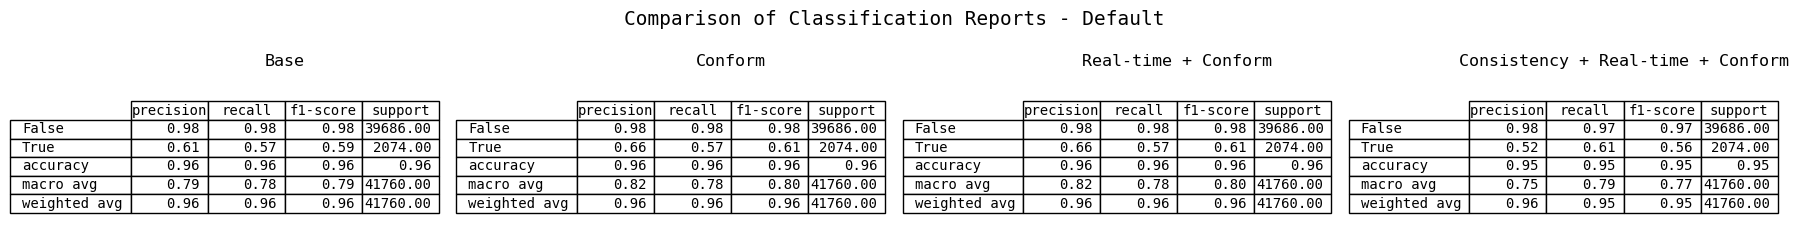

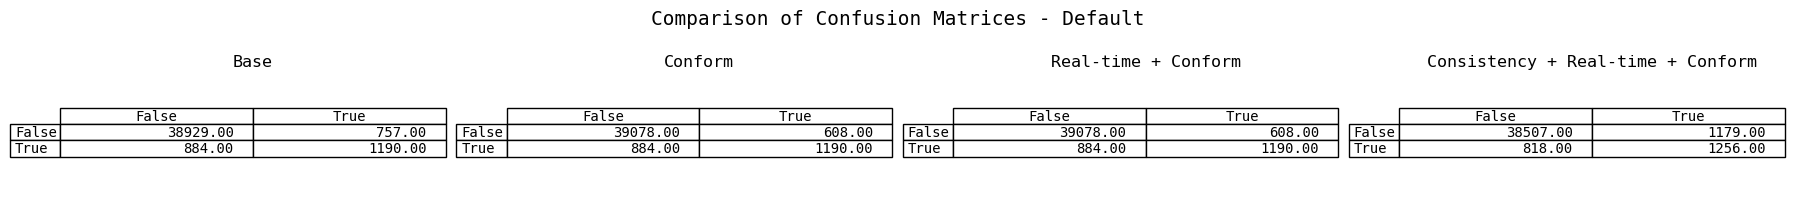

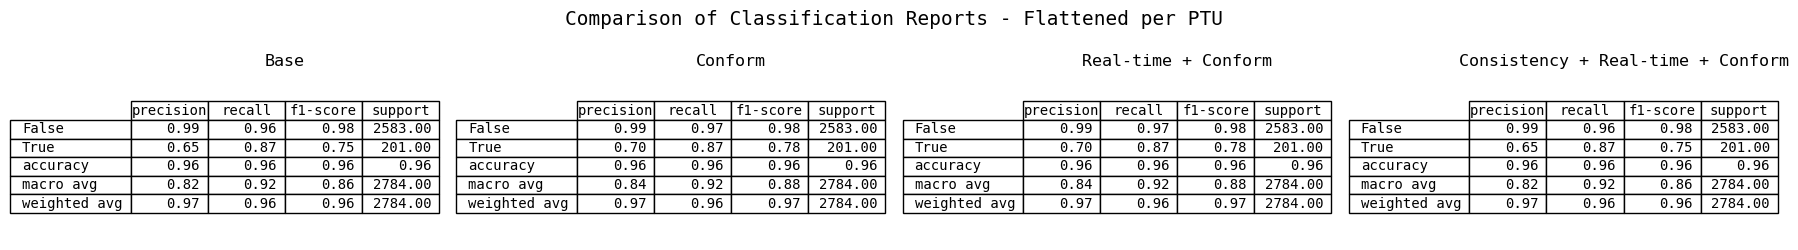

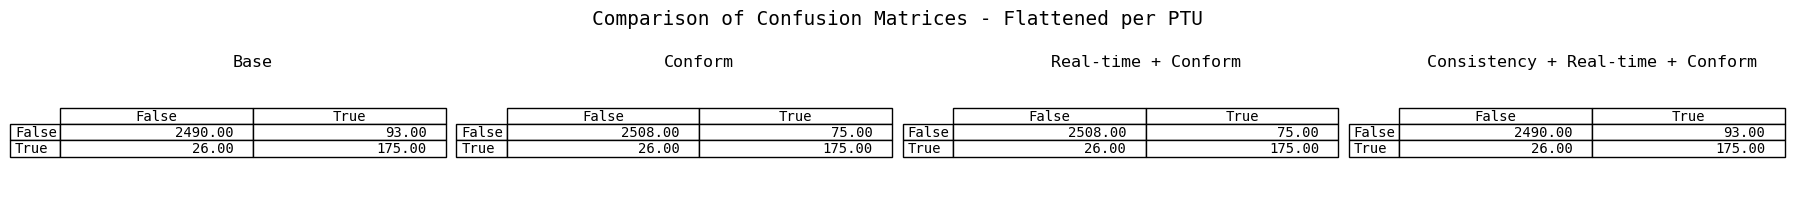

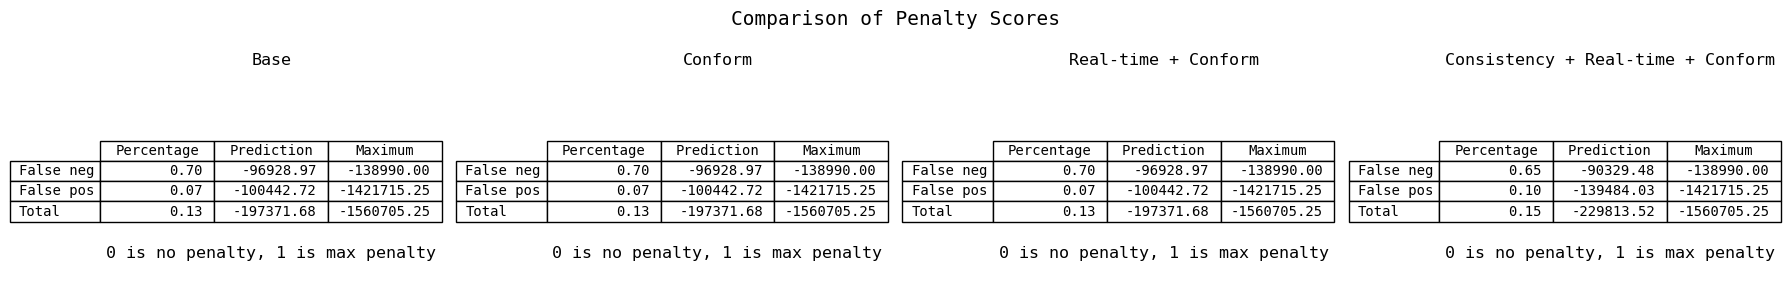

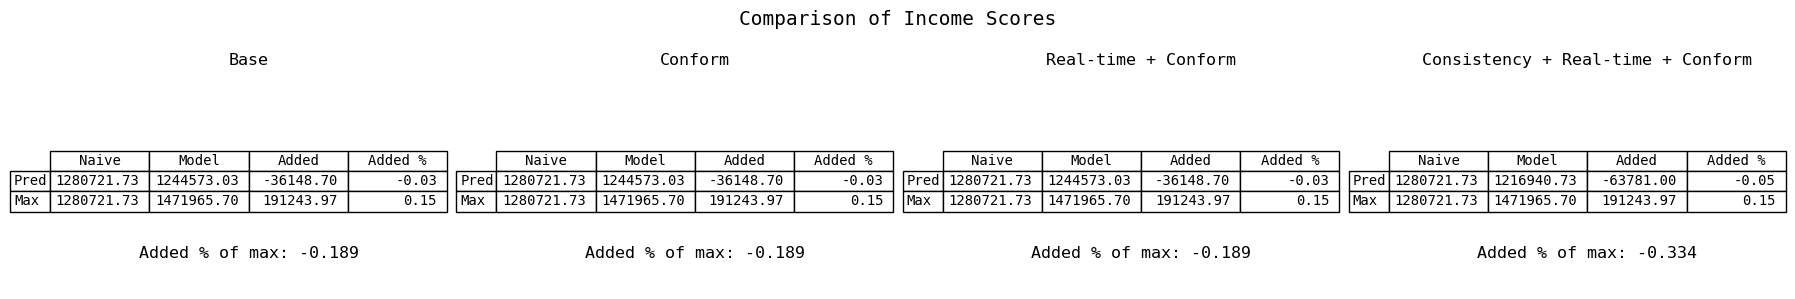

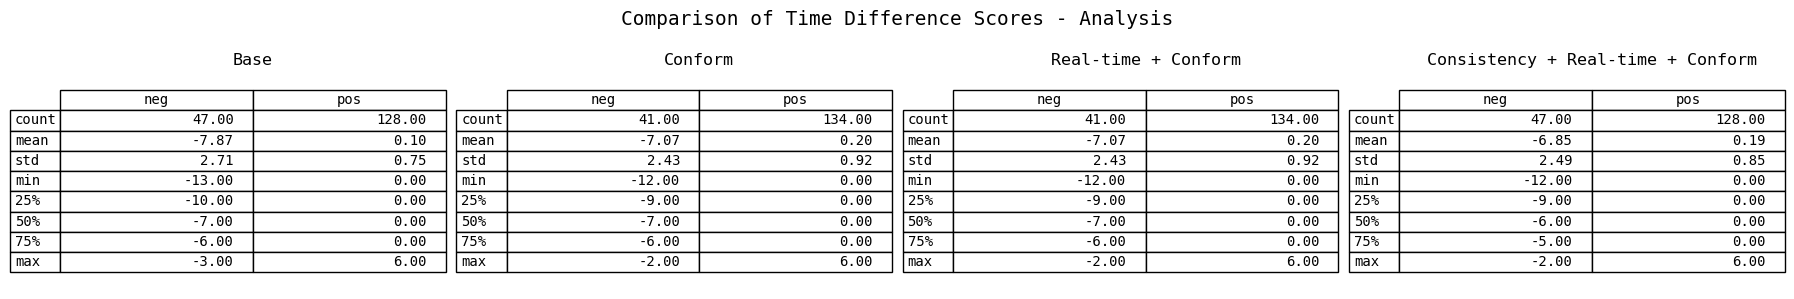

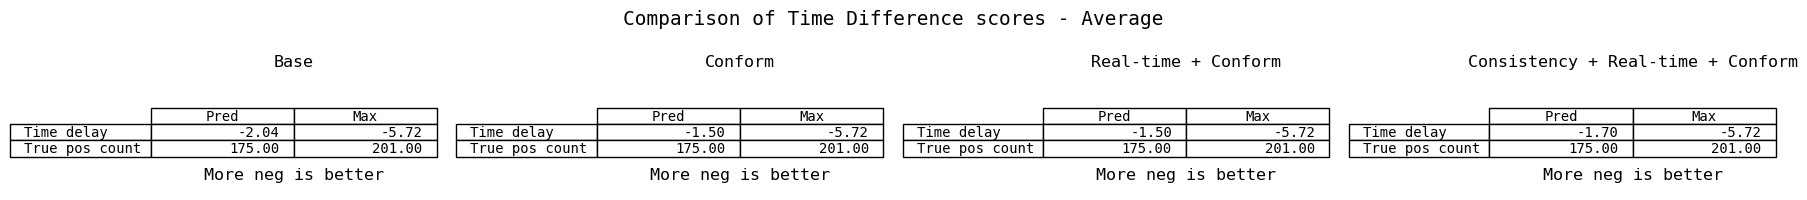

In [2]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "settlement_price_bestguess",
    "time_since_last_two_sided",
    "two_sided_daily_count",
    "PTU",
    "naive_strategy_action",
    "forecast_wind",
    "forecast_solar",
    "forecast_demand",
    "target_two_sided_ptu_realtime"
]
splits = get_splits(df, features, target, return_dict_pair=False)
# m = RandomForestClassifier(n_estimators=50)
# m = HistGradientBoostingRegressor(loss="poisson")
m = HistGradientBoostingClassifier(random_state=42)
m.fit(splits[train_set][0], splits[train_set][1])
p = m.predict(splits[test_set][0])
# p = p > 0.5
p1 = recast_pred(p)
show_metrics_adjusted(splits[test_set][3], p1, version=version)

# train on fix test on target
# split target and two side
# only check ptu start with neg or naive=true, for train or metric

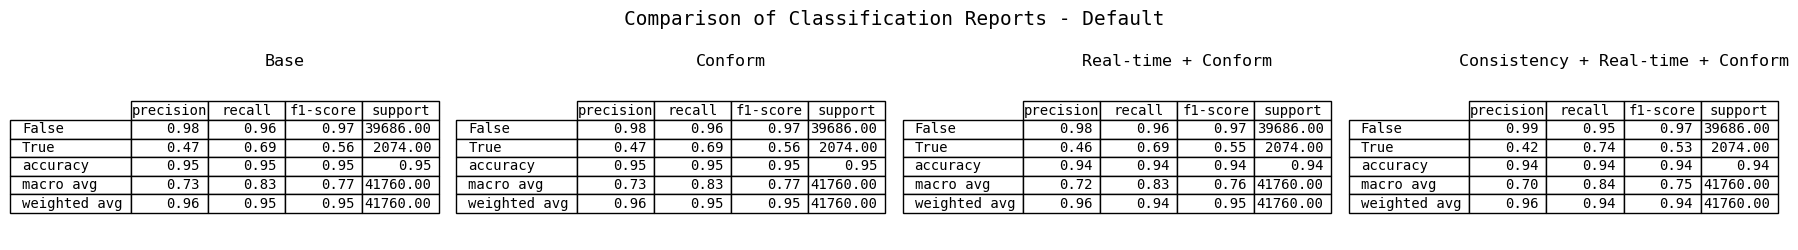

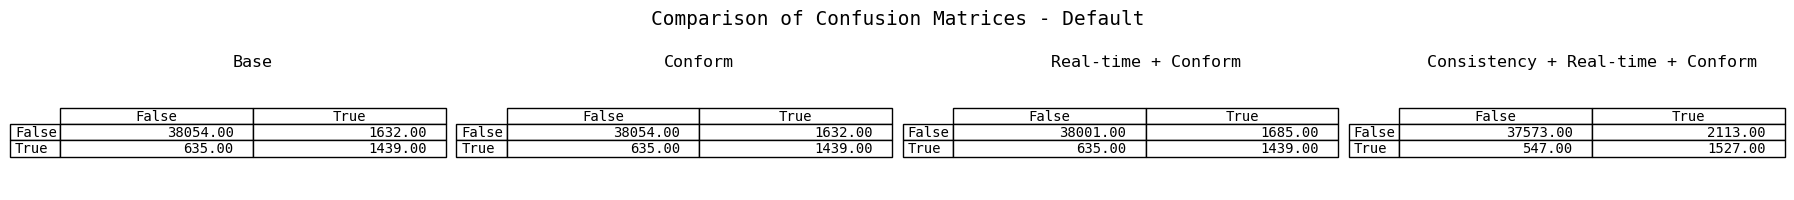

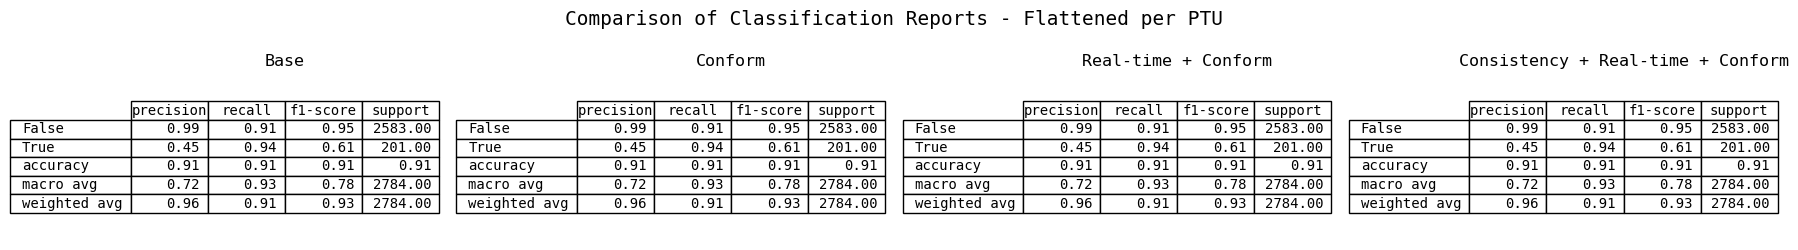

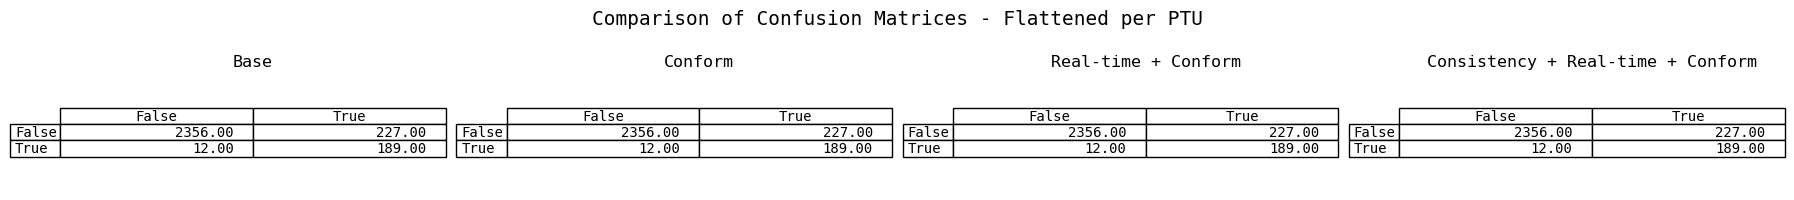

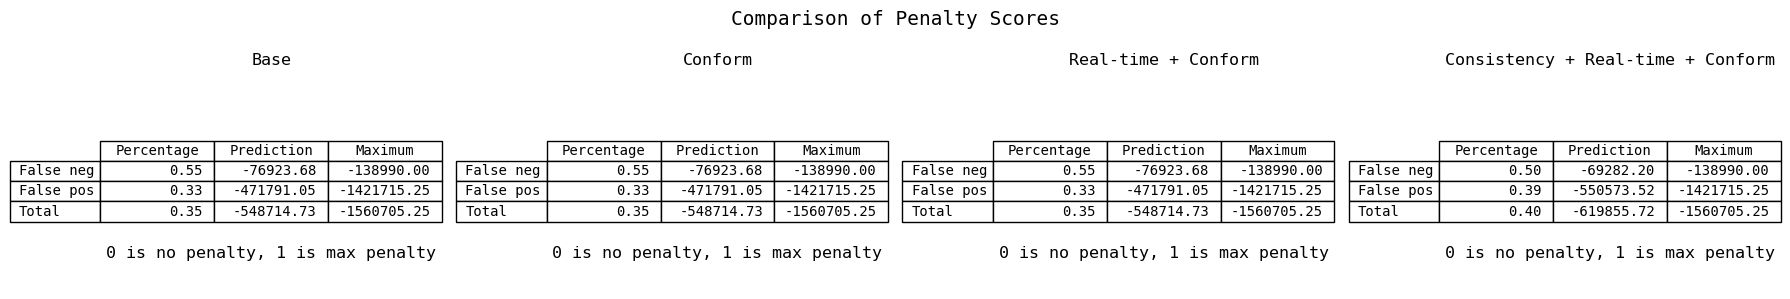

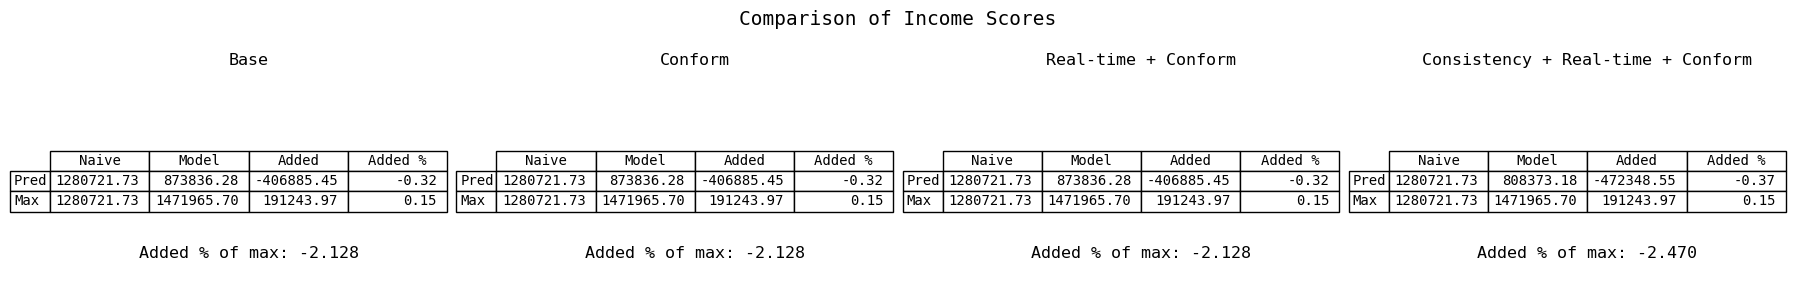

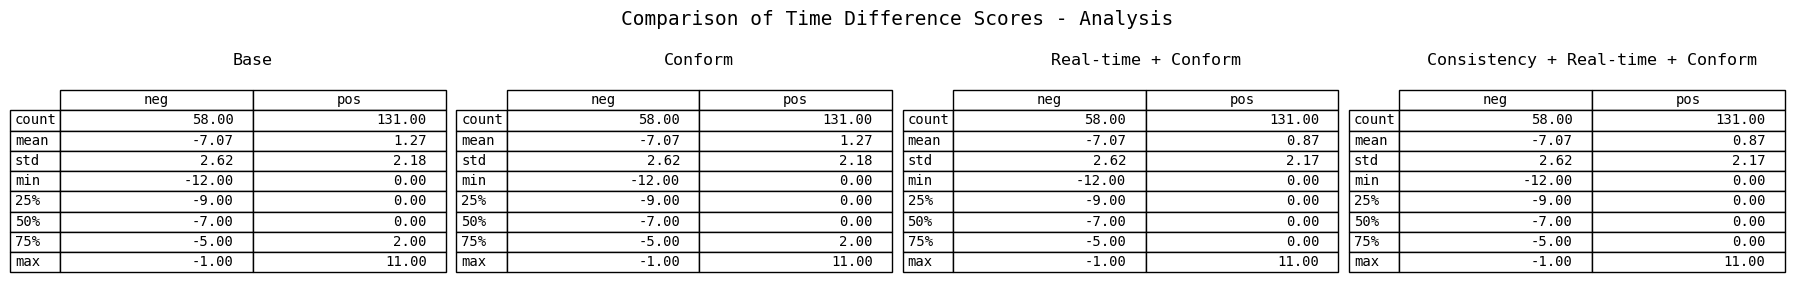

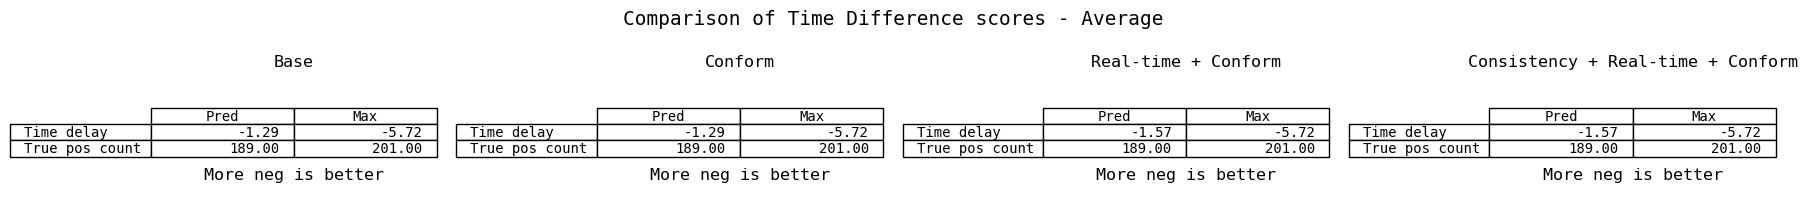

In [3]:
# features = ["mid_price_published", "minute_in_ptu", "time_since_last_two_sided",
#        "vwap_avg", "PTU", "forecast_demand", "ptu_id", "residual_load",
#        "dispatch_diff", "igcc_diff"]

features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "upward_dispatch_published",
    "downward_dispatch_published",
    'min_ptu_price_known',
    "max_ptu_price_known",
    "settlement_price_bestguess",
    'naive_strategy_action',
    'PTU',
    'forecast_wind',
    'forecast_solar',
    'forecast_demand',
    'target_two_sided_ptu_realtime',
]
splits = get_splits(df, features, target, return_dict_pair=False)
# m = RandomForestClassifier(n_estimators=50)
# m = HistGradientBoostingRegressor(loss="poisson", l2_regularization=4)
# m = HistGradientBoostingClassifier()
# m.fit(splits[train_set][0], splits[train_set][1])
m = load_model("xgboost")
p = m.predict(splits[test_set][0])
# p = p > 0.5
p2 = recast_pred(p)
show_metrics_adjusted(splits[test_set][3], p2, version=version)

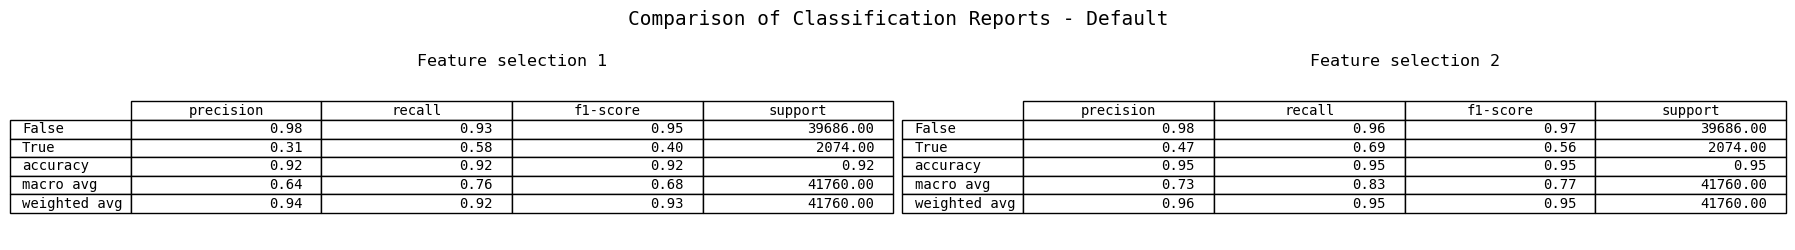

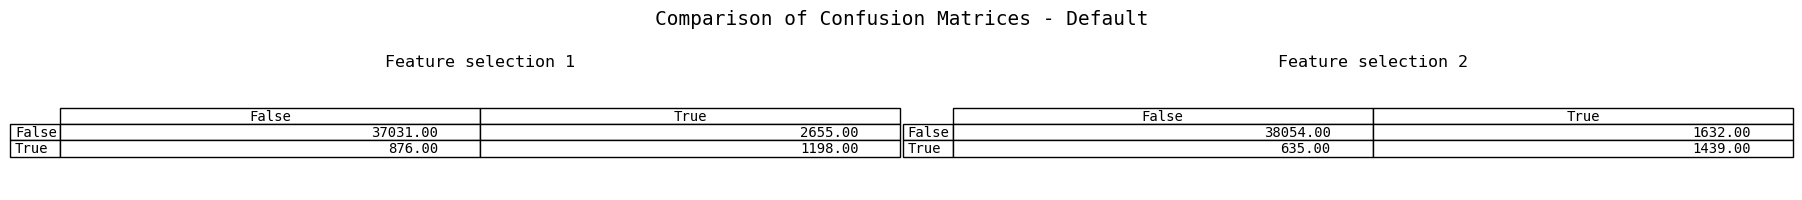

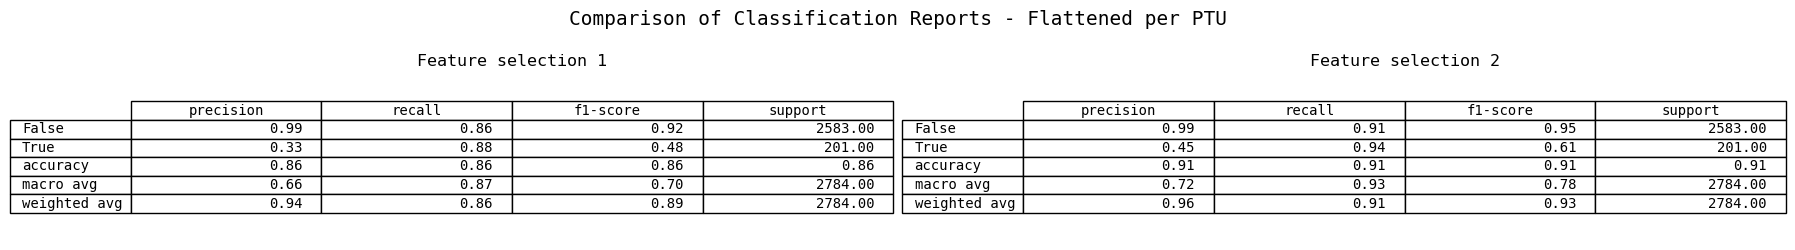

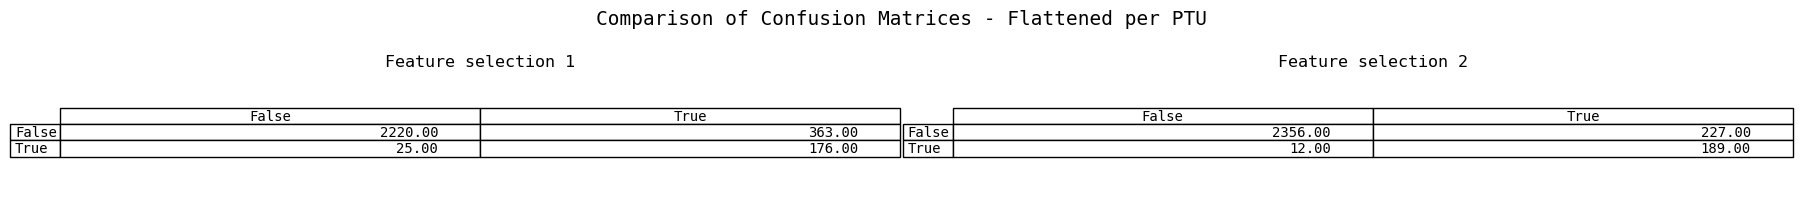

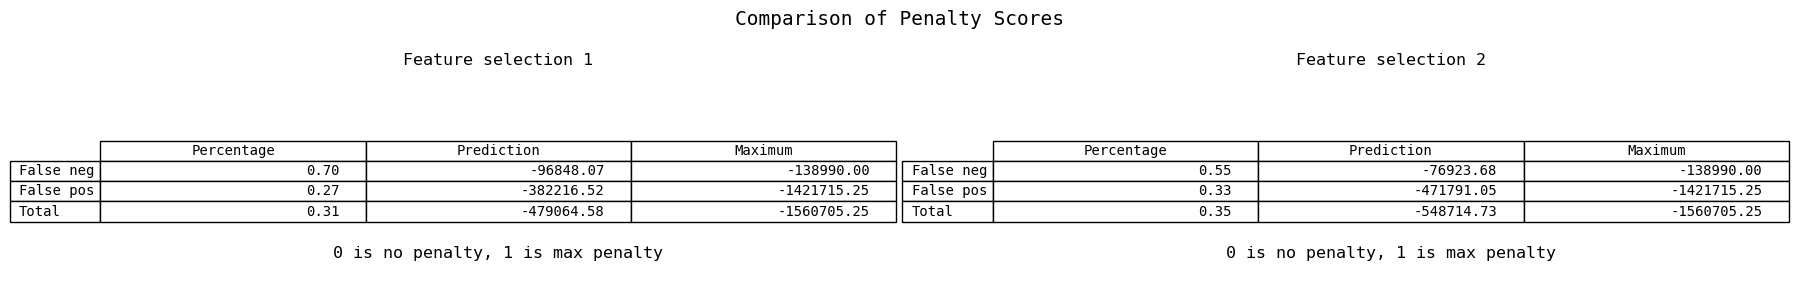

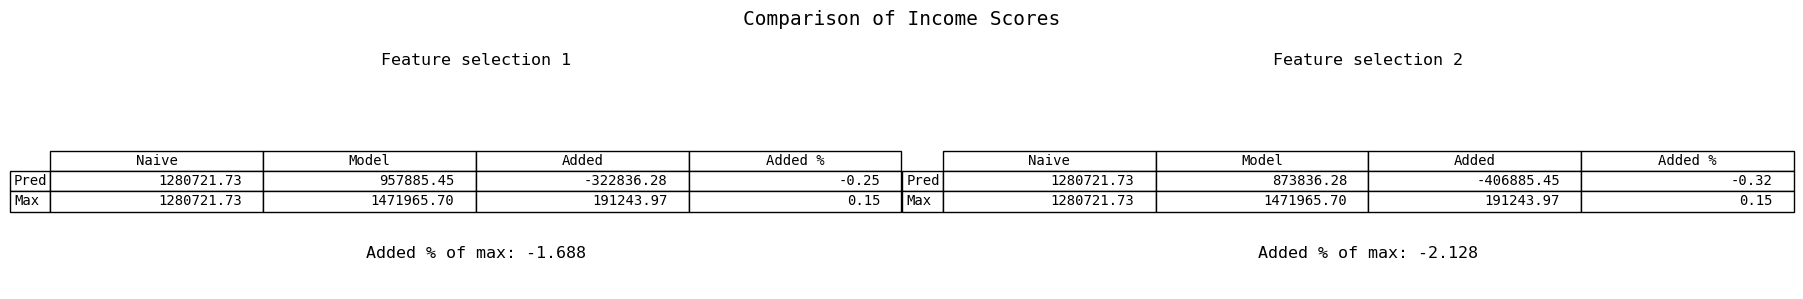

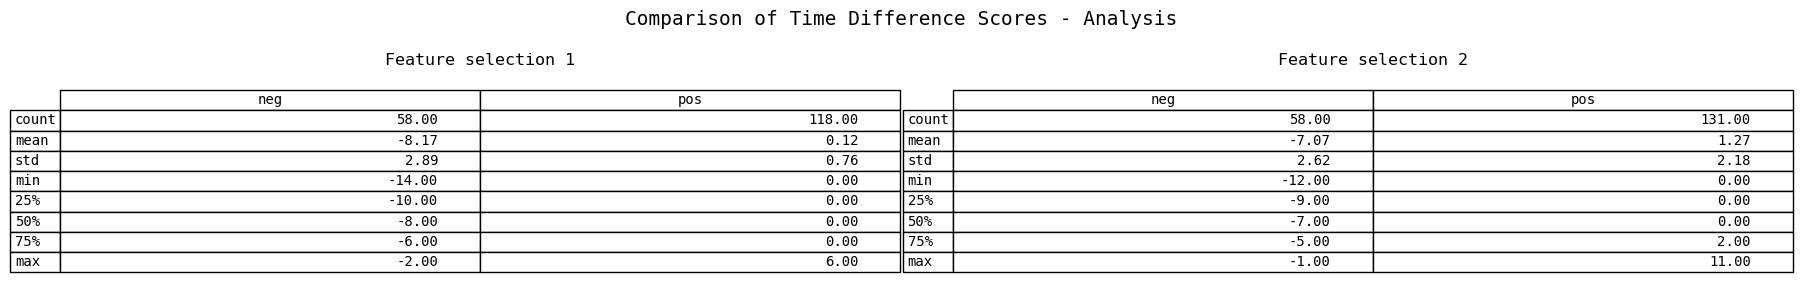

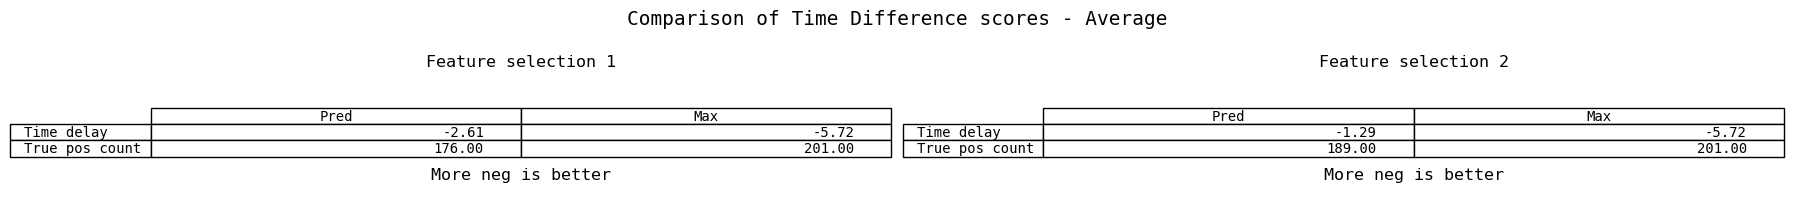

In [4]:
show_metrics_multi(splits[test_set][3], [p1, p2], titles=["Feature selection 1", "Feature selection 2"], version=version)